# Spatial perturbation tasks on mouse brain data

In [1]:
import os
import sys
sys.path.append("../")
device = "cuda"
import importlib


In [2]:
import scanpy as sc
import squidpy as sq
import pandas as pd
from tqdm.notebook import tqdm
import scipy as sp
import numpy as np
import multiprocessing
import pickle as pkl
import torch
import gc
import sklearn.metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rc('pdf', fonttype=42)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
import steamboat as sf
import steamboat.tools

In [4]:
import torch

In [5]:
adata = sc.read_h5ad("saved_h5ad/mmbrain_0.h5ad")

In [6]:
model = sf.Steamboat(adata.var_names.tolist(), n_heads=50, n_scales=3)
model = model.to(device)
model.load_state_dict(torch.load('saved_models/mmbrain.pth', weights_only=True), strict=False)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


_IncompatibleKeys(missing_keys=[], unexpected_keys=['spatial_gather.w_local._scale', 'spatial_gather.w_global._scale'])

In [7]:
import importlib
importlib.reload(steamboat.tools)

<module 'steamboat.tools' from 'G:\\Projects\\Steamboat\\examples\\..\\steamboat\\tools.py'>

['Gbx2' 'Trdn' 'Edaradd' 'Hoxb3' 'Barhl2' 'Sec14l5' 'Mog' 'C030029H02Rik'
 'Cldn11' 'Sox10' 'Dgkk' 'Drd2' 'Onecut2' 'Mafa' 'Gabra6' 'Cnpy1' 'Grm3'
 'Sema6a' 'Ermn' 'Nr2e1' 'Emx2os' 'Sstr1' 'Drd1' 'Grin2c' 'Mfge8' 'S1pr1']


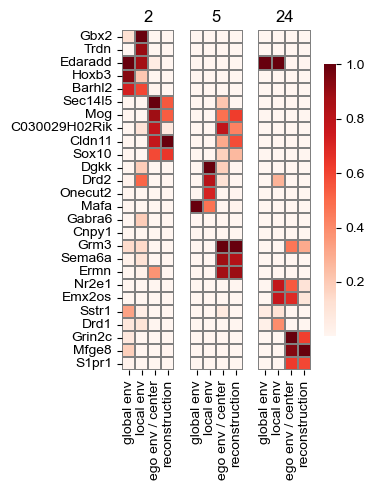

In [8]:
model.features = adata.var['gene_symbol']
sf.tools.plot_all_transforms(model, top=3, head_order=[2, 5, 24], figsize=(4, 5))
# # plt.savefig(fig_path + "crc_all_loadings.pdf", bbox_inches='tight')

## Spatial perturbation scenario 1: transplanting cells

### Designate cells to be "transplanted"

In [9]:
# Find OPC-Oligo in two regions

adata.obs['class_region'] = adata.obs['class'].astype(str) + '@' + adata.obs['parcellation_division'].astype(str)
adata.obs['oligo_class_region'] = adata.obs['class_region']
adata.obs.loc[adata.obs['class_region'] != '31 OPC-Oligo', 'oligo_class_region'] = '98 Other'

In [10]:
# Confirm that there are some expression differences in OPC-Oligo in two regions.

oligo_adata = adata[adata.obs['class_region'].isin(['31 OPC-Oligo@Isocortex', '31 OPC-Oligo@HPF'])]

In [11]:
oligo_adata.obs['class_region'].value_counts()

class_region
31 OPC-Oligo@HPF          980
31 OPC-Oligo@Isocortex    784
Name: count, dtype: int64

In [12]:
sc.tl.rank_genes_groups(oligo_adata, groupby='class_region', reference='31 OPC-Oligo@Isocortex', method='wilcoxon')

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [13]:
sc.get.rank_genes_groups_df(oligo_adata, group='31 OPC-Oligo@HPF')

,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSMUSG00000020932,13.187178,2.604712,1.040073e-39,1.166962e-36
1,ENSMUSG00000090291,5.466264,4.215365,4.596197e-08,6.446167e-06
2,ENSMUSG00000023913,3.856600,0.769698,1.149752e-04,9.146835e-03
3,ENSMUSG00000031980,3.806837,2.439926,1.407553e-04,9.870467e-03
4,ENSMUSG00000053930,3.645979,2.021932,2.663758e-04,1.758080e-02
...,...,...,...,...,...
1117,ENSMUSG00000058624,-6.016663,-1.100518,1.780497e-09,3.329530e-07
1118,ENSMUSG00000033730,-6.205130,-2.224680,5.465168e-10,1.226384e-07
1119,ENSMUSG00000070570,-6.513019,-0.717460,7.365549e-11,2.066036e-08
1120,ENSMUSG00000047907,-6.625102,-2.285636,3.470090e-11,1.297814e-08


In [14]:
old_adata = adata.copy()
new_adata = adata.copy()

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


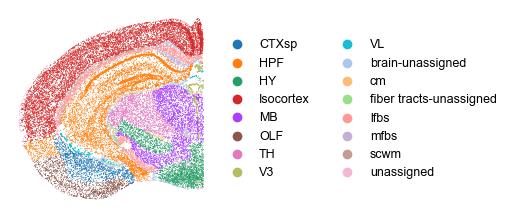

In [15]:
sq.pl.spatial_scatter(old_adata, color='parcellation_division', shape=None, figsize=(5, 5), size=1., lw=0., legend_fontsize=9, title="", frameon=False)

In [16]:
repalcement_class = '31 OPC-Oligo@Isocortex'
to_be_replaced_class = '31 OPC-Oligo@HPF'
new_name = '31 OPC-Oligo@Isocortex->HPF'

n = 200
np.random.seed(0)
replacement = np.random.choice(np.where(new_adata.obs['class_region'] == repalcement_class)[0], n, replace=False)
to_be_replaced = np.random.choice(np.where(new_adata.obs['class_region'] == to_be_replaced_class)[0], n, replace=False)

### Reconstruct the gene expression

In [17]:
new_adata.X[to_be_replaced, :] = new_adata.X[replacement, :]
new_adata.obs['class2'] = new_adata.obs['class_region'].tolist()
new_adata.obs.loc[new_adata.obs_names[to_be_replaced], 'class2'] = new_name

new_dataset = sf.make_dataset([new_adata], sparse_graph=True, regional_obs=['global'])
sf.tools.calc_obs([new_adata], new_dataset, model, get_recon=True)
new_adata.X = new_adata.obsm['X_recon']

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Perform DE analysis

In [18]:
highlight = [repalcement_class, new_name, to_be_replaced_class]
sc.tl.rank_genes_groups(new_adata, groupby='class2', groups=highlight, reference=repalcement_class, method='wilcoxon')

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [19]:
a_df = pd.merge(sc.get.rank_genes_groups_df(new_adata, group=to_be_replaced_class), new_adata.var, right_index=True, left_on='names')
b_df = pd.merge(sc.get.rank_genes_groups_df(new_adata, group=new_name), new_adata.var, right_index=True, left_on='names')
ab_df = pd.merge(a_df, b_df, left_on='names', right_on='names')

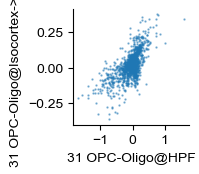

In [20]:
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'
matplotlib.rc('pdf', fonttype=42)

fig, ax = plt.subplots(figsize=(1.5, 1.5))
ab_df.plot(kind='scatter', x='logfoldchanges_x', y='logfoldchanges_y', s=0.5, ax=ax, alpha=.5)
ax.set_xlabel(to_be_replaced_class)
ax.set_ylabel(new_name)

for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)

# plt.savefig(savefig_path + "mmbrain_perturbation_logfc.pdf", bbox_inches='tight', transparent=True)

In [21]:
ab_df2 = ab_df[~ab_df['logfoldchanges_x'].isna() & ~ab_df['logfoldchanges_y'].isna()]
sp.stats.spearmanr(ab_df2['logfoldchanges_x'], ab_df2['logfoldchanges_y'])

SignificanceResult(statistic=0.6419909066233113, pvalue=2.277434802943895e-131)

In [22]:
ab_df[['logfoldchanges_x', 'logfoldchanges_y']].corr(method='spearman')

,logfoldchanges_x,logfoldchanges_y
logfoldchanges_x,1.000000,0.641991
logfoldchanges_y,0.641991,1.000000


In [23]:
ab_df[['logfoldchanges_x', 'logfoldchanges_y']].corr(method='pearson')
# 0.475

,logfoldchanges_x,logfoldchanges_y
logfoldchanges_x,1.000000,0.680731
logfoldchanges_y,0.680731,1.000000


## Spatial perturbation scenario 2: changing environment.

### Overview the variability of expression of genes

C:\Users\lshh\AppData\Local\Temp\ipykernel_116268\147967129.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_rearrange.obs['class'] = adata_rearrange.obs['class'].astype(str)


C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


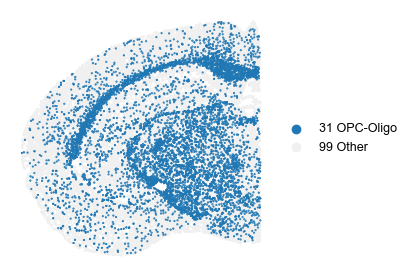

In [38]:
adata_rearrange = adata[np.where(~adata.obs['class'].isin(['31 OPC-Oligo']))[0].tolist() + 
                        np.where(adata.obs['class'].isin(['31 OPC-Oligo']))[0].tolist()]
adata_rearrange.obs['class'] = adata_rearrange.obs['class'].astype(str)
adata_rearrange.obs.loc[adata_rearrange.obs['class'] != '31 OPC-Oligo', 'class'] = '99 Other'
sq.pl.spatial_scatter(adata_rearrange, color='class', shape=None, figsize=(4, 4), size=1., legend_fontsize=9, title="", frameon=False,
                      palette=matplotlib.colors.ListedColormap(['C0', '#f0f0f0']))
# plt.savefig(savefig_path + "mmbrain_KO_scheme.pdf", bbox_inches='tight', transparent=True)

In [39]:
wt_adata = adata.copy()
ko_adata = adata.copy()

In [40]:
pd.Series((wt_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0]].std(axis=0)/
           wt_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0]].mean(axis=0)), index=adata.var['gene_symbol']).sort_values()

gene_symbol
Sox10      0.298431
Nfix       0.443308
Cldn11     0.455745
Mog        0.514136
Pou3f3     0.569786
            ...    
Lhx4      28.757689
Npffr2    28.905586
Fgf3      29.486641
Scgn      29.530397
Hoxb8     30.028955
Length: 1122, dtype: float32

In [41]:
dispersion_df = pd.DataFrame([wt_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0]].var(axis=0), 
             wt_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0]].mean(axis=0)],
             columns=adata.var['gene_symbol'],
             index=['var', 'mean']).T
dispersion_df['dispersion'] = dispersion_df['var'] / dispersion_df['mean']
dispersion_df = dispersion_df[dispersion_df['mean'] > 1.]
dispersion_df.sort_values('dispersion', ascending=False)

,var,mean,dispersion
gene_symbol,,,
Grm3,0.706748,1.044864,0.676402
Ermn,0.840322,1.308472,0.642216
Cldn11,1.662142,2.828864,0.587565
Sec14l5,0.932986,1.588670,0.587275
Sulf2,0.736025,1.312926,0.560599
Sema6a,0.627580,1.130927,0.554925
Mog,1.162848,2.097412,0.554421
Zfp536,0.711731,1.330900,0.534774
Gprc5b,0.698224,1.348250,0.517874


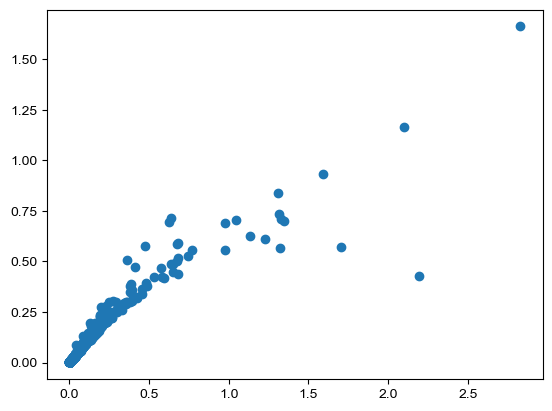

In [42]:
plt.scatter(wt_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0]].mean(axis=0), 
            wt_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0]].var(axis=0))

### Remove *Mog* from OPC-Oligo and reconstruct cells

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

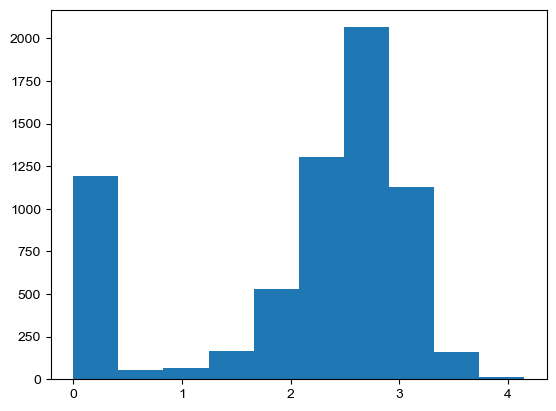

In [43]:
ko_gene = 'Mog'

plt.hist(ko_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0], 
         np.where(ko_adata.var['gene_symbol'] == ko_gene)[0][0]])
ko_adata.X[np.where(ko_adata.obs['class'] == '31 OPC-Oligo')[0], 
           np.where(ko_adata.var['gene_symbol'] == ko_gene)[0][0]] = 0
ko_dataset = sf.make_dataset([ko_adata], sparse_graph=True, regional_obs=['global'])
sf.tools.calc_obs([ko_adata], ko_dataset, model, get_recon=True)

wt_dataset = sf.make_dataset([wt_adata], sparse_graph=True, regional_obs=['global'])
sf.tools.calc_obs([wt_adata], wt_dataset, model, get_recon=True)

In [44]:
gene_rmse = ((ko_adata.obsm['X_recon'] - wt_adata.obsm['X_recon']) ** 2).sum(axis=0) ** .5

In [45]:
cell_rmse = ((ko_adata.obsm['X_recon'] - wt_adata.obsm['X_recon']) ** 2).sum(axis=1) ** .5

In [46]:
cell_rmse

array([0.01820022, 0.04508448, 0.04385628, ..., 0.03686631, 0.04018443,
       0.02311902], dtype=float32)

In [47]:
ko_adata.obs['cell_rmse'] = cell_rmse

(0.0, 0.2)

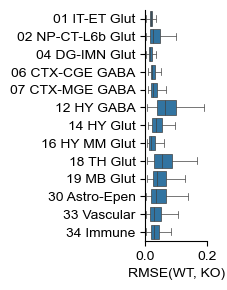

In [48]:
fig, ax = plt.subplots(figsize=(.8, 3))
my_obs = ko_adata.obs.copy()
my_obs['class'] = my_obs['class'].tolist()
my_obs = my_obs.sort_values('class')
class_count = my_obs['class'].value_counts()
chosen_classes = class_count[class_count > (class_count.sum()) * 0.005].index.tolist()
chosen_classes.remove('31 OPC-Oligo')
sns.boxplot(my_obs[my_obs['class'].isin(chosen_classes)], y='class', x='cell_rmse', 
            fliersize=.0, linewidth=.5, ax=ax)
#ax.set_yticklabels(ax.get_yticklabels(), rotation=30, ha='right', va='top', rotation_mode='anchor')
ax.set_ylabel("")
ax.set_xlabel("RMSE(WT, KO)")
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)
plt.xlim([0, .2])
# plt.savefig(savefig_path + "mmbrain_perturbation_cell_mse.pdf", transparent=True, bbox_inches='tight')

C:\Users\lshh\AppData\Local\Temp\ipykernel_116268\945811404.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', va='center', rotation_mode='anchor')


(0.0, 0.2)

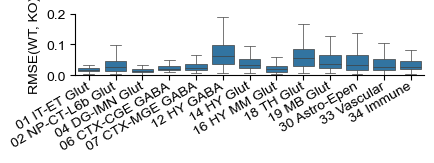

In [49]:
fig, ax = plt.subplots(figsize=(4.5, .8))
my_obs = ko_adata.obs.copy()
my_obs['class'] = my_obs['class'].tolist()
my_obs = my_obs.sort_values('class')
class_count = my_obs['class'].value_counts()
chosen_classes = class_count[class_count > (class_count.sum()) * 0.005].index.tolist()
chosen_classes.remove('31 OPC-Oligo')
sns.boxplot(my_obs[my_obs['class'].isin(chosen_classes)], x='class', y='cell_rmse', 
            fliersize=.0, linewidth=.5, ax=ax)
#ax.set_yticklabels(ax.get_yticklabels(), rotation=30, ha='right', va='top', rotation_mode='anchor')
ax.set_ylabel("RMSE(WT, KO)")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', va='center', rotation_mode='anchor')
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)
plt.ylim([0, .2])
# plt.savefig(savefig_path + "mmbrain_perturbation_cell_mse.pdf", transparent=True, bbox_inches='tight')

In [50]:
x = wt_adata.obsm['X_recon'][wt_adata.obs['class'] == '31 OPC-Oligo', :]
y = ko_adata.obsm['X_recon'][ko_adata.obs['class'] == '31 OPC-Oligo', :]
cmp_adata = sc.AnnData(np.vstack([x, y]), var=ko_adata.var.copy())
cmp_adata.var_names = cmp_adata.var['gene_symbol']
cmp_adata.obs['grp'] = ['WT'] * x.shape[0] + ['KO'] * y.shape[0]
sc.tl.rank_genes_groups(cmp_adata, groupby='grp', method='wilcoxon')
cmp_df = sc.get.rank_genes_groups_df(cmp_adata, group="KO")
cmp_df

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,names,scores,logfoldchanges,pvals,pvals_adj
0,Pif1,16.773153,0.083190,3.835997e-63,4.303989e-60
1,Diaph3,14.955308,0.079347,1.438155e-50,8.068052e-48
2,Clspn,14.882693,0.067352,4.269589e-50,1.596826e-47
3,Slfn9,14.656121,0.064221,1.231072e-48,3.453157e-46
4,Nfib,13.375875,0.069715,8.366315e-41,1.341001e-38
...,...,...,...,...,...
1117,Sec14l5,-11.687506,-0.152907,1.476599e-31,8.283721e-30
1118,Cldn11,-12.559337,-0.239797,3.532823e-36,3.303190e-34
1119,Zfp536,-13.351248,-0.143543,1.164816e-40,1.633655e-38
1120,Sox10,-13.862960,-0.142347,1.062029e-43,1.985995e-41


In [51]:
celltype = '12 HY GABA'
x = wt_adata.obsm['X_recon'][(wt_adata.obs['class'] == celltype), :]
y = ko_adata.obsm['X_recon'][(ko_adata.obs['class'] == celltype), :]
cmp_adata = sc.AnnData(np.vstack([x, y]), var=ko_adata.var.copy())
cmp_adata.var_names = cmp_adata.var['gene_symbol']
cmp_adata.obs['grp'] = ['WT'] * x.shape[0] + ['KO'] * y.shape[0]
sc.tl.rank_genes_groups(cmp_adata, groupby='grp', reference='WT', method='wilcoxon')
cmp_df = sc.get.rank_genes_groups_df(cmp_adata, group="KO")
cmp_df

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,names,scores,logfoldchanges,pvals,pvals_adj
0,Slc35d3,0.756400,0.013487,0.449409,0.999606
1,Kirrel,0.742567,0.014942,0.457744,0.999606
2,Sfrp1,0.733180,0.011120,0.463449,0.999606
3,Satb1,0.711935,0.017550,0.476505,0.999606
4,Il1rap,0.702054,0.010552,0.482645,0.999606
...,...,...,...,...,...
1117,Tspear,-0.681304,-0.015128,0.495679,0.999606
1118,Tnc,-0.696125,-0.024466,0.486350,0.999606
1119,Pappa2,-0.729721,-0.018365,0.465561,0.999606
1120,Pax3,-0.729721,-0.021977,0.465561,0.999606


### GSEA on DEs

In [52]:
import gseapy
from gseapy import Msigdb

msig = Msigdb()
gmt = msig.get_gmt(category='c5.go.bp', dbver="2024.1.Hs")

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\gseapy\msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\gseapy\msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


In [53]:
gene_df = cmp_df.copy()
gene_df.index = cmp_df['names'].str.upper()

gsea_res = gseapy.prerank(rnk=gene_df['scores'], # or rnk = rnk,
                          gene_sets=gmt,
                          threads=5,
                          min_size=5,
                          max_size=1000,
                          permutation_num=1000, # reduce number to speed up testing
                          outdir=None, # don't write to disk
                          seed=0,
                          verbose=True, # see what's going on behind the scenes
                          )

grea_res_selected = gsea_res.res2d[(gsea_res.res2d['NOM p-val'] < 0.01) & (gsea_res.res2d['FDR q-val'] < 0.2)]

2025-03-03 17:52:50,598 [WARNING] Duplicated values found in preranked stats: 36.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-03 17:52:50,598 [INFO] Parsing data files for GSEA.............................
2025-03-03 17:52:50,688 [INFO] 5396 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-03-03 17:52:50,689 [INFO] 2212 gene_sets used for further statistical testing.....
2025-03-03 17:52:50,690 [INFO] Start to run GSEA...Might take a while..................
2025-03-03 17:52:55,533 [INFO] Congratulations. GSEApy runs successfully................



In [54]:
grea_res_selected

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOBP_TELENCEPHALON_DEVELOPMENT,0.482072,2.151512,0.0,0.0786,0.048,33/58,31.37%,SLC32A1;ARX;ERBB4;DLX2;LHX6;BCL11B;OXTR;NR2E1;...
1,prerank,GOBP_PALLIUM_DEVELOPMENT,0.546905,2.149917,0.0,0.039896,0.049,19/34,23.71%,SLC32A1;ARX;DLX2;LHX6;NR2E1;PROX1;DRD1;EGFR;AL...
2,prerank,GOBP_REGULATION_OF_ORGAN_GROWTH,0.725254,2.047186,0.001608,0.106388,0.16,7/11,7.13%,ARX;ERBB4;COL14A1;IGF1;ZFPM2;PROX1;RBP4
3,prerank,GOBP_FOREBRAIN_DEVELOPMENT,0.419623,2.040435,0.0,0.086937,0.172,45/91,29.06%,SLC32A1;ARX;ERBB4;DLX2;LHX6;BCL11B;SOX2;LHX8;O...
4,prerank,GOBP_CEREBRAL_CORTEX_CELL_MIGRATION,0.676108,2.031769,0.0,0.0786,0.196,8/13,22.37%,ARX;LHX6;NR2E1;EGFR;RELN;FGF13;SLIT2;POU3F3
5,prerank,GOBP_FOREBRAIN_GENERATION_OF_NEURONS,0.572954,1.984345,0.0,0.131596,0.355,11/21,18.81%,DLX2;LHX6;BCL11B;LHX8;NR2E1;PROX1;SOX1;GATA2;N...
6,prerank,GOBP_HIPPOCAMPUS_DEVELOPMENT,0.591436,1.956173,0.0,0.163665,0.457,11/19,18.63%,SLC32A1;DLX2;NR2E1;PROX1;DRD1;ALK;RELN;FGF13;Z...


In [55]:
def func(x):
    x = x[5:]
    return x.replace('_', ' ').lower()
grea_res_selected['Term2'] = grea_res_selected['Term'].apply(func)

C:\Users\lshh\AppData\Local\Temp\ipykernel_116268\2450731809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grea_res_selected['Term2'] = grea_res_selected['Term'].apply(func)


C:\Users\lshh\AppData\Local\Temp\ipykernel_116268\2706694812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grea_res_selected['-log(q)'] = -np.log10(grea_res_selected['FDR q-val'].astype(float))


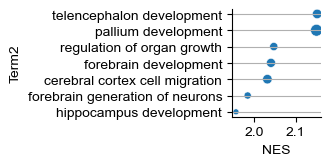

In [56]:
grea_res_selected['-log(q)'] = -np.log10(grea_res_selected['FDR q-val'].astype(float))
fig = sns.relplot(grea_res_selected, y='Term2', x='NES', size='-log(q)', legend=False)
plt.gcf().set_size_inches(1.8, 1.25)
plt.grid(axis='y', zorder=0)
# plt.savefig(savefig_path + "mmbrain_perturbation_go.pdf", transparent=True, bbox_inches='tight')